In [1]:
# For if you want to just be working in your cloned git directory, and not installed to a python environment
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [2]:
import ccd
from test.shared import read_data

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [4]:
params = {'QA_BITPACKED': False,
              'QA_FILL': 255,
              'QA_CLEAR': 0,
              'QA_WATER': 1,
              'QA_SHADOW': 2,
              'QA_SNOW': 3,
              'QA_CLOUD': 4}

In [5]:
data = read_data('../test/resources/test_3657_3610_observations.csv')
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas = data
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, params=params)

Start Date: 1982-12-04 00:00:00
End Date: 2014-11-02 00:00:00

Result: 0
Start Date: 1984-05-23 00:00:00
End Date: 1993-06-01 00:00:00
Break Date: 1993-06-17 00:00:00
QA: 8
Norm: 2600.4931939326316
Change prob: 1
Blue: [  4.58314743e-02   3.33345234e+02   6.21344097e+01   5.41421085e+01
   3.10319812e+01   2.50845892e+01   4.91272964e+00]
Green: [  4.87907159e-02   3.26802375e+02   3.67446381e+01   4.78360842e+01
   1.10423621e+01   2.06916027e+01  -9.02650313e+00]
Red: [  8.41903913e-02   5.46777638e+02  -8.72414168e+00   3.74124079e+01
  -6.03337432e+01   4.81676540e+00  -5.16853149e+01]
NIR: [ -6.44149821e-02  -2.93256284e+02  -1.79480553e+02   1.73335148e+02
   4.94866551e+01  -4.43830337e+01   1.40287464e+02]
SWIR1: [  7.82904523e-02   1.80730585e+02  -2.06790010e+02  -2.21747517e+02
  -1.60016098e+02  -6.66320146e+00  -1.83629053e+02]
SWIR2: [  8.55359710e-02   2.27229388e+02  -1.45321621e+01  -2.42494899e+02
  -1.56464516e+02   1.17483079e+01  -1.80476099e+02]
Thermal: [  2.2298

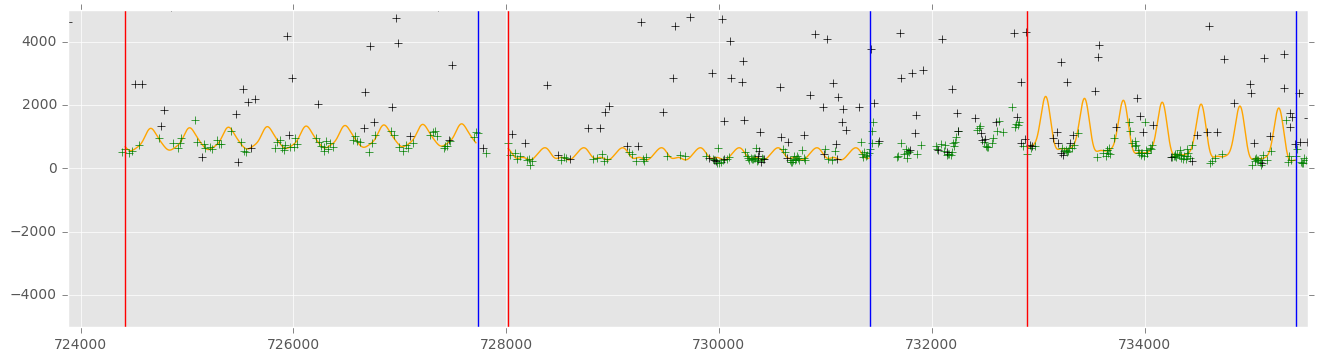

In [6]:
mask = results['processing_mask']
print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
                                                datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result.start_day)))
    print('End Date: {}'.format(datetime.fromordinal(result.end_day)))
    print('Break Date: {}'.format(datetime.fromordinal(result.break_day)))
    print('QA: {}'.format(result.curve_qa))
    print('Norm: {}'.format(np.linalg.norm([result.green.magnitude,
                                            result.red.magnitude,
                                            result.nir.magnitude,
                                            result.swir1.magnitude,
                                            result.swir2.magnitude])))
    print('Change prob: {}'.format(result.change_probability))
    print('Blue: {}'.format(result.blue.coefficients))
    print('Green: {}'.format(result.green.coefficients))
    print('Red: {}'.format(result.red.coefficients))
    print('NIR: {}'.format(result.nir.coefficients))
    print('SWIR1: {}'.format(result.swir1.coefficients))
    print('SWIR2: {}'.format(result.swir2.coefficients))
    print('Thermal: {}\n'.format(result.thermal.coefficients))
    
    days = np.arange(result.start_day, result.end_day + 1)
    prediction_dates.append(days)
    break_dates.append(result.break_day)
    start_dates.append(result.start_day)
    
    intercept = result.green.intercept
    coef = result.green.coefficients
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], greens[mask], 'g+') # Observed values
a1.plot(dates[~mask], greens[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')